In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import gymnasium as gym
import gym_trading_env
from gym_trading_env.environments import dynamic_feature_last_position_taken

from RLTrade.agent import DQNAgent, XGBoostAgent
from RLTrade.utils import (
    stationary_dgp, 
    make_ohlc,
    FeatureEngineering
)

import plotly.graph_objects as go

Matplotlib is building the font cache; this may take a moment.


In [68]:
N, window, stride = 100000, 24, 24  # simulation with ohlc
# N, window, stride = 10000, 1, 1  # simulation with tick data

x_c, y_c = stationary_dgp(N=N)
y_o, y_h, y_l, y_c = make_ohlc(y_c, window=window, stride=stride)
x_o, x_h, x_l, x_c = make_ohlc(x_c, window=window, stride=stride)
spread_o, spread_h, spread_l, spread_c = y_o - x_o, y_h - x_l, y_l - x_h, y_c - x_c

df = pd.DataFrame({'open': spread_o, 'high': spread_h, 'low': spread_l, 'close': spread_c})
df.index = pd.date_range(start='2020-01-01', periods=len(df), freq='D')

In [69]:
fig = go.Figure(data=[go.Candlestick(x=df.index, open=x_o, high=x_h, low=x_l, close=x_c)])
fig.update_layout(title='Candlestick Char of X', xaxis_title='Day interval', yaxis_title='Price')
fig.show()

In [70]:
fig = go.Figure(data=[go.Candlestick(x=df.index, open=df['open'], high=df['high'], low=df['low'], close=df['close'])])
fig.update_layout(title='Candlestick Chart of Y - X', xaxis_title='Day interval', yaxis_title='Price')
fig.show()

In [71]:
# confirm the x, y pair is cointegrated, such that spread is stationary
x_ols = sm.add_constant(x_c)
ols = sm.OLS(y_c, x_ols).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 5.420e+06
Date:                Tue, 13 May 2025   Prob (F-statistic):               0.00
Time:                        00:31:24   Log-Likelihood:                 172.60
No. Observations:                4166   AIC:                            -341.2
Df Residuals:                    4164   BIC:                            -328.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         99.9982      0.007   1.37e+04      0.0

In [72]:
adfuller_test = adfuller(spread_c)
print(f'ADF Statistic: {adfuller_test[0]}')
print(f'p-value: {adfuller_test[1]}')
print('Is the spread stationary? {}'.format('Yes' if adfuller_test[1] < 0.05 else 'No'))

ADF Statistic: -41.75836231995925
p-value: 0.0
Is the spread stationary? Yes


In [73]:
feature_config = [
    {'type': 'rolling',
     'params': {
       'cols': ['close'],
       'window': 7,
       'mode': 'logdiff',
       'subtract_mean': False
     }},
]

df_train = df.copy()
fe = FeatureEngineering(df_train)
df_train = fe.build_features(feature_config)

In [74]:
# Define the environment
env_action_space = [-1, 0, 1] # Positions : [-1=SHORT, 0=OUT, 1=LONG]
# env_action_space = [i/10 for i in range(-10, 11)] # Positions : [-1, -0.9, -0.8, ..., 0, 0.1, 0.2, ..., 1]

env = gym.make("TradingEnv",
        name= "stationary_dgp",
        df = df_train, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        # dynamic_feature_functions = [],
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        # max_episode_duration=180
    )
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
print(observation)

while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(position_index)

n_actions = env.action_space.n
n_observations = len(env.reset()[0])

[ 0.  0.  0.  0.  0.  0.  0. -1. -1.]
Market Return : -0.08%   |   Portfolio Return : -30.43%   |   Position Changes : 2826   |   Episode Length : 4166   |   


In [75]:
df_train

,open,high,low,close,feature_close_lag_0,feature_close_lag_1,feature_close_lag_2,feature_close_lag_3,feature_close_lag_4,feature_close_lag_5,feature_close_lag_6
2020-01-01,99.747962,100.314419,99.460607,100.138898,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-02,100.114959,100.568228,99.810830,100.293499,0.001543,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-03,100.231802,100.627485,99.581709,99.978432,-0.003146,0.001543,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-04,100.030948,100.402345,99.510587,100.226270,0.002476,-0.003146,0.001543,0.000000,0.000000,0.000000,0.000000
2020-01-05,100.126649,100.724198,99.342382,99.964278,-0.002617,0.002476,-0.003146,0.001543,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2031-05-24,100.235479,100.496112,99.867057,100.189177,0.000513,-0.000673,0.004199,-0.007327,0.003377,-0.001280,0.000679
2031-05-25,100.203148,100.357439,99.615836,100.067088,-0.001219,0.000513,-0.000673,0.004199,-0.007327,0.003377,-0.001280
2031-05-26,99.970056,100.716842,99.156015,99.828899,-0.002383,-0.001219,0.000513,-0.000673,0.004199,-0.007327,0.003377
2031-05-27,99.785153,100.584522,99.288559,100.150239,0.003214,-0.002383,-0.001219,0.000513,-0.000673,0.004199,-0.007327


In [76]:
# Train a DQN agent using training data from a stationary data generating process
agent = DQNAgent(n_observations=n_observations, n_actions=n_actions, target_net_layers=[8], policy_net_layers=[8])
history_metrics, _ = agent.train(env, num_episodes=15) # Beware of overfitting when num_episodes is too high

Market Return : -0.08%   |   Portfolio Return : -42.43%   |   Position Changes : 1703   |   Episode Length : 4166   |   
Market Return : -0.08%   |   Portfolio Return : -18.81%   |   Position Changes : 932   |   Episode Length : 4166   |   
Market Return : -0.08%   |   Portfolio Return : 70.74%   |   Position Changes : 3438   |   Episode Length : 4166   |   
Market Return : -0.08%   |   Portfolio Return : 990.52%   |   Position Changes : 1790   |   Episode Length : 4166   |   
Market Return : -0.08%   |   Portfolio Return : 2160.89%   |   Position Changes : 1881   |   Episode Length : 4166   |   
Market Return : -0.08%   |   Portfolio Return : 2563.73%   |   Position Changes : 1958   |   Episode Length : 4166   |   
Market Return : -0.08%   |   Portfolio Return : 2568.25%   |   Position Changes : 2036   |   Episode Length : 4166   |   
Market Return : -0.08%   |   Portfolio Return : 3112.80%   |   Position Changes : 2122   |   Episode Length : 4166   |   
Market Return : -0.08%   |   P

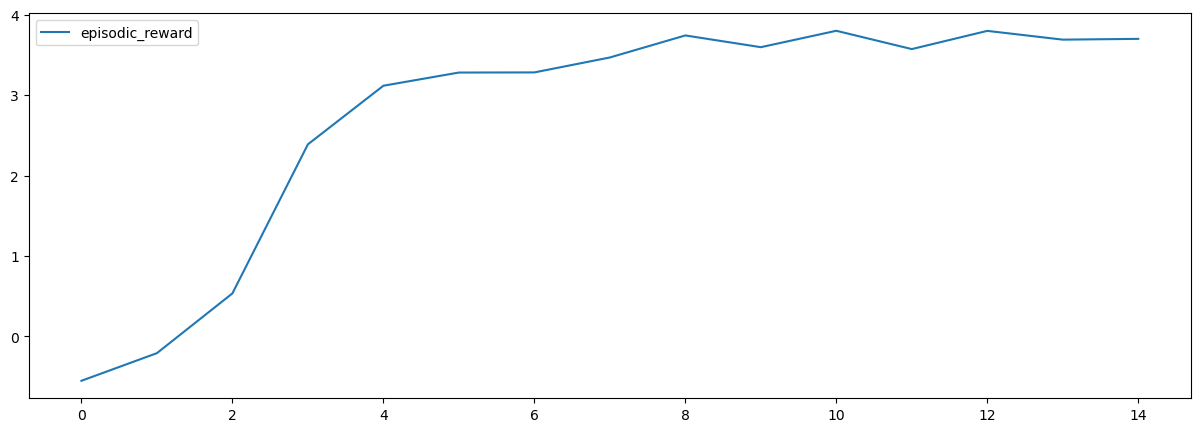

In [81]:
all_metrics = pd.DataFrame(history_metrics)
perc2float = lambda x: float(x.strip('%'))/100

all_metrics["Market Return"] = all_metrics["Market Return"].apply(perc2float)
all_metrics["Portfolio Return"] = all_metrics["Portfolio Return"].apply(perc2float)

all_metrics.plot(y=["episodic_reward"], figsize=(15, 5))
plt.show()

In [82]:
# Evaluate the agent on a new dataset from the same data generating process
returns = []
for i in range(10):
    x_c, y_c = stationary_dgp(N=N)
    y_o, y_h, y_l, y_c = make_ohlc(y_c, window=window, stride=stride)
    x_o, x_h, x_l, x_c = make_ohlc(x_c, window=window, stride=stride)
    spread_o, spread_h, spread_l, spread_c = y_o - x_o, y_h - x_l, y_l - x_h, y_c - x_c

    _df = pd.DataFrame({'open': spread_o, 'high': spread_h, 'low': spread_l, 'close': spread_c})
    _df["volume"] = 0
    _df.index = pd.date_range(start='2020-01-01', periods=len(df), freq='D')

    fe = FeatureEngineering(_df)
    _df = fe.build_features(feature_config)
    
    env_test = gym.make("TradingEnv",
            name= "stationary_dgp_qlearning",
            df = _df, # Your dataset with your custom features
            positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
            # dynamic_feature_functions = [],
            trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
            borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        )
    env_test.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
    env_test.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

    env_test = agent.eval(env_test)
    returns.append(perc2float(env_test.unwrapped.get_metrics()["Portfolio Return"]))

print(f"Average Portfolio Return: {np.mean(returns)}")
print(f"Std Portfolio Return: {np.std(returns)}")

Market Return :  0.40%   |   Portfolio Return : 4089.59%   |   Position Changes : 2137   |   Episode Length : 4166   |   
Market Return :  0.23%   |   Portfolio Return : 5076.89%   |   Position Changes : 2173   |   Episode Length : 4166   |   
Market Return : -0.09%   |   Portfolio Return : 3238.95%   |   Position Changes : 2051   |   Episode Length : 4166   |   
Market Return : -0.33%   |   Portfolio Return : 3597.16%   |   Position Changes : 2128   |   Episode Length : 4166   |   
Market Return : -0.19%   |   Portfolio Return : 4609.23%   |   Position Changes : 2149   |   Episode Length : 4166   |   
Market Return :  0.22%   |   Portfolio Return : 5947.07%   |   Position Changes : 2169   |   Episode Length : 4166   |   
Market Return :  0.38%   |   Portfolio Return : 4878.74%   |   Position Changes : 2142   |   Episode Length : 4166   |   
Market Return :  0.02%   |   Portfolio Return : 4135.68%   |   Position Changes : 2110   |   Episode Length : 4166   |   
Market Return : -0.29%  

In [83]:
history = [env_test.unwrapped.historical_info[i] for i in range(len(env_test.unwrapped.historical_info))]
historical_info_df = pd.DataFrame(history)
historical_info_df.columns

Index(['idx', 'step', 'date', 'position_index', 'position', 'real_position',
       'data_low', 'data_volume', 'data_close', 'data_high', 'data_open',
       'portfolio_valuation', 'portfolio_distribution_asset',
       'portfolio_distribution_fiat', 'portfolio_distribution_borrowed_asset',
       'portfolio_distribution_borrowed_fiat',
       'portfolio_distribution_interest_asset',
       'portfolio_distribution_interest_fiat', 'reward'],
      dtype='object')

In [98]:
historical_info_df.index

RangeIndex(start=0, stop=4166, step=1)

In [115]:
sample = historical_info_df.iloc[0:100]

from plotly.subplots import make_subplots
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
    row_heights=[0.7, 0.3],
    subplot_titles=["Price Candlestick", "Portfolio Value"]
)

fig.add_trace(go.Candlestick(
    x=sample.index,
    open=sample['data_open'],
    high=sample['data_high'],
    low=sample['data_low'],
    close=sample['data_close'],
    name="Price"
))

buy_signals = sample[(sample["position"] == 1)]
sell_signals = sample[(sample["position"] == -1)]
exit_signals = sample[(sample["position"] == 0)]

# Add buy markers
fig.add_trace(go.Scatter(
    x=buy_signals.index,
    y=buy_signals['data_close'],
    mode='markers',
    marker=dict(color='green', size=10, symbol='triangle-up'),
    name='Buy'
))

# Add sell markers
fig.add_trace(go.Scatter(
    x=sell_signals.index,
    y=sell_signals['data_close'],
    mode='markers',
    marker=dict(color='red', size=10, symbol='triangle-down'),
    name='Sell'
))

# --- Row 2: Portfolio Value ---
fig.add_trace(go.Scatter(
    x=sample.index,
    y=sample['portfolio_valuation'],
    mode='lines',
    line=dict(color='blue'),
    name="Portfolio Value"
), row=2, col=1)


fig.update_layout(xaxis_rangeslider_visible=False)

In [109]:
buy_signals

,idx,step,date,position_index,position,real_position,data_low,data_volume,data_close,data_high,data_open,portfolio_valuation,portfolio_distribution_asset,portfolio_distribution_fiat,portfolio_distribution_borrowed_asset,portfolio_distribution_borrowed_fiat,portfolio_distribution_interest_asset,portfolio_distribution_interest_fiat,reward
5,5,5,2020-01-06,2,1,0.999997,99.536686,0.0,100.084738,100.501774,99.754822,1007.590370,10.067343,0.002990,0.0,0,0.0,0.0,0.004341
7,7,7,2020-01-08,2,1,0.999997,99.842521,0.0,100.085679,100.531194,99.882418,1011.361274,10.104925,0.003016,0.0,0,0.0,0.0,0.001878
13,13,13,2020-01-14,2,1,0.999997,99.481706,0.0,100.171744,100.405989,99.930934,1014.534134,10.127917,0.003029,0.0,0,0.0,0.0,0.002000
15,15,15,2020-01-16,2,1,0.999997,99.434055,0.0,100.096226,100.597367,99.960401,1018.771775,10.177894,0.003035,0.0,0,0.0,0.0,0.001714
17,17,17,2020-01-18,2,1,0.999997,99.208749,0.0,99.381437,100.093209,99.865886,1016.586707,10.229110,0.003047,0.0,0,0.0,0.0,-0.004650
24,24,24,2020-01-25,2,1,0.999997,99.088422,0.0,99.884843,100.301173,99.633968,1016.797382,10.179666,0.003056,0.0,0,0.0,0.0,0.002635
27,27,27,2020-01-28,2,1,0.999997,99.464383,0.0,99.821847,100.238342,99.767464,1019.442924,10.212593,0.003044,0.0,0,0.0,0.0,0.000989
36,36,36,2020-02-06,2,1,0.999997,99.558765,0.0,100.043058,100.208132,99.775730,1024.579664,10.241356,0.003053,0.0,0,0.0,0.0,0.003624
39,39,39,2020-02-09,2,1,0.999997,99.480406,0.0,100.139281,100.508745,99.680581,1029.704563,10.282693,0.003066,0.0,0,0.0,0.0,0.002981
41,41,41,2020-02-11,2,1,0.999997,99.603783,0.0,99.953226,100.449235,99.919009,1033.365691,10.338462,0.003080,0.0,0,0.0,0.0,0.000852


In [92]:
short_pos_median = historical_info_df.loc[historical_info_df["position"] == -1, "data_close"].median()
short_pos_mean = historical_info_df.loc[historical_info_df["position"] == -1, "data_close"].mean()
long_pos_median = historical_info_df.loc[historical_info_df["position"] == 1, "data_close"].median()
long_pos_mean = historical_info_df.loc[historical_info_df["position"] == 1, "data_close"].mean()
exit_pos_median = historical_info_df.loc[historical_info_df["position"] == 0, "data_close"].median()
exit_pos_mean = historical_info_df.loc[historical_info_df["position"] == 0, "data_close"].mean()

num_positions = historical_info_df["position"].value_counts()

# Count the number of positions by price
mean = historical_info_df["data_close"].mean()
num_pos_by_mean = historical_info_df.loc[historical_info_df["data_close"] > mean, "position"].value_counts()

print(num_positions)
print(num_pos_by_mean)
print(short_pos_median, short_pos_mean)
print(long_pos_median, long_pos_mean)
print(exit_pos_median, exit_pos_mean)

position
-1    3082
 1    1083
 0       1
Name: count, dtype: int64
position
-1    1583
 1     515
Name: count, dtype: int64
100.00571734982219 100.0004409906093
99.98190006589417 99.98960462919578
99.96447977471227 99.96447977471227


In [44]:
env_test.unwrapped.save_for_render(dir = "render_logs")

In [45]:
# build features
df_train = df.copy()

feature_config = [
    # {'type': 'rolling',
    #  'params': {
    #    'cols': ['close'],
    #    'window': 7,
    #    'mode': 'diff',
    #    'subtract_mean': False
    #  }},
    {'type': 'select',
     'params': {
         'cols': ['close'],
     }}
]

fe = FeatureEngineering(df_train)
fe.build_features(feature_config)
df_train = fe.df.copy()
df_train

,open,high,low,close,feature_close
2020-01-01,100.274783,100.931526,99.770595,100.088155,100.088155
2020-01-02,100.182074,100.813688,99.884881,100.341834,100.341834
2020-01-03,100.123069,100.453070,99.395412,99.763859,99.763859
2020-01-04,99.726369,100.177368,99.405936,99.801130,99.801130
2020-01-05,99.875138,100.449086,99.325822,99.860206,99.860206
...,...,...,...,...,...
2031-05-24,100.174890,100.373525,99.472301,100.061737,100.061737
2031-05-25,99.950370,100.320272,99.435691,99.830900,99.830900
2031-05-26,99.753843,100.392467,99.361605,99.965848,99.965848
2031-05-27,99.957662,100.568135,99.517305,99.871263,99.871263


In [46]:
# Define the environment
env_action_space = [-1, 0, 1] # Positions : [-1=SHORT, 0=OUT, 1=LONG]
# env_action_space = [i/10 for i in range(-10, 11)] # Positions : [-1, -0.9, -0.8, ..., 0, 0.1, 0.2, ..., 1]

env = gym.make("TradingEnv",
        name= "stationary_dgp",
        df = df_train, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        # dynamic_feature_functions = [dynamic_feature_last_position_taken],
        # max_episode_duration=180
    )
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
print(observation)
while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(0)

n_actions = env.action_space.n
n_observations = len(env.reset()[0])

[100.08816  -1.       -1.     ]
Market Return :  0.06%   |   Portfolio Return : -0.06%   |   Position Changes : 0   |   Episode Length : 4166   |   


In [47]:
agent = XGBoostAgent(n_observations, n_actions)
history_metrics, _ = agent.train(env, num_episodes=20, replay_every=2)

Market Return :  0.06%   |   Portfolio Return : -14.13%   |   Position Changes : 2836   |   Episode Length : 4166   |   
Market Return :  0.06%   |   Portfolio Return : -12.12%   |   Position Changes : 2753   |   Episode Length : 4166   |   
Market Return :  0.06%   |   Portfolio Return : 878.39%   |   Position Changes : 2732   |   Episode Length : 4166   |   
Market Return :  0.06%   |   Portfolio Return : 780.00%   |   Position Changes : 2763   |   Episode Length : 4166   |   
Market Return :  0.06%   |   Portfolio Return : 10435.71%   |   Position Changes : 2550   |   Episode Length : 4166   |   
Market Return :  0.06%   |   Portfolio Return : 8748.23%   |   Position Changes : 2546   |   Episode Length : 4166   |   
Market Return :  0.06%   |   Portfolio Return : 32770.79%   |   Position Changes : 2380   |   Episode Length : 4166   |   
Market Return :  0.06%   |   Portfolio Return : 26297.89%   |   Position Changes : 2391   |   Episode Length : 4166   |   
Market Return :  0.06%   

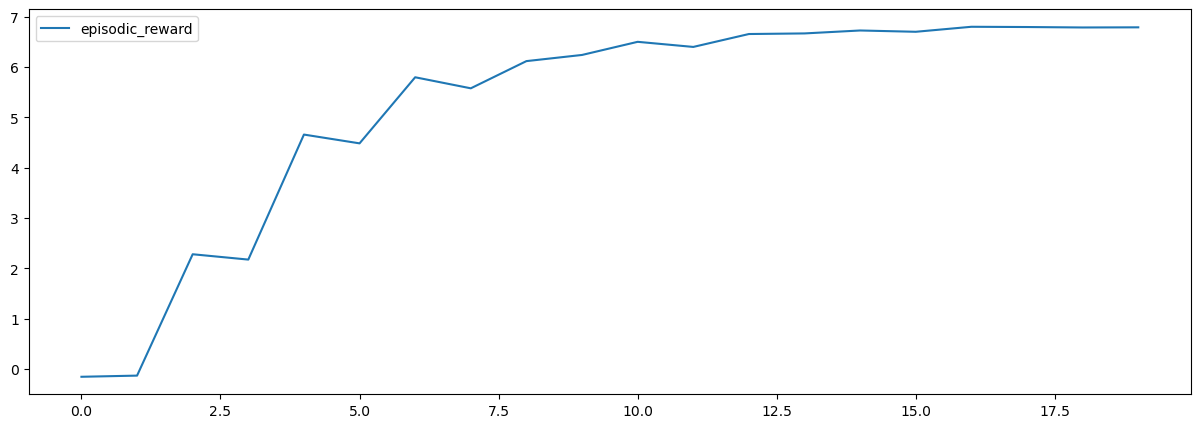

In [48]:
all_metrics = pd.DataFrame(history_metrics)
perc2float = lambda x: float(x.strip('%'))/100

all_metrics["Market Return"] = all_metrics["Market Return"].apply(perc2float)
all_metrics["Portfolio Return"] = all_metrics["Portfolio Return"].apply(perc2float)

all_metrics.plot(y=["episodic_reward"], figsize=(15, 5))
plt.show()

In [50]:
# Evaluate the agent on a new dataset from the same data generating process
returns = []
for i in range(10):
    x_c, y_c = stationary_dgp(N=N)
    y_o, y_h, y_l, y_c = make_ohlc(y_c, window=window, stride=stride)
    x_o, x_h, x_l, x_c = make_ohlc(x_c, window=window, stride=stride)
    spread_o, spread_h, spread_l, spread_c = y_o - x_o, y_h - x_l, y_l - x_h, y_c - x_c

    _df = pd.DataFrame({'open': spread_o, 'high': spread_h, 'low': spread_l, 'close': spread_c})
    _df["volume"] = 0
    _df.index = pd.date_range(start='2020-01-01', periods=len(df), freq='D')
    fe = FeatureEngineering(_df)
    fe.build_features(feature_config)
    _df = fe.df.copy()

    env_test = gym.make("TradingEnv",
            name= "stationary_dgp_xgboost",
            df = _df, # Your dataset with your custom features
            positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
            trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
            borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
            # dynamic_feature_functions = [dynamic_feature_last_position_taken],
        )
    env_test.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
    env_test.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

    env_test = agent.eval(env_test)
    returns.append(perc2float(env_test.unwrapped.get_metrics()["Portfolio Return"]))

print(f"Average Portfolio Return: {np.mean(returns)}")
print(f"Std Portfolio Return: {np.std(returns)}")

Market Return : -0.06%   |   Portfolio Return : 53718.80%   |   Position Changes : 2108   |   Episode Length : 4166   |   
Market Return : -0.28%   |   Portfolio Return : 72133.43%   |   Position Changes : 2108   |   Episode Length : 4166   |   
Market Return :  0.06%   |   Portfolio Return : 51999.57%   |   Position Changes : 2103   |   Episode Length : 4166   |   
Market Return :  0.15%   |   Portfolio Return : 53251.45%   |   Position Changes : 2119   |   Episode Length : 4166   |   
Market Return : -0.16%   |   Portfolio Return : 61541.18%   |   Position Changes : 2150   |   Episode Length : 4166   |   
Market Return :  0.02%   |   Portfolio Return : 54214.36%   |   Position Changes : 2079   |   Episode Length : 4166   |   
Market Return :  0.31%   |   Portfolio Return : 43484.28%   |   Position Changes : 2083   |   Episode Length : 4166   |   
Market Return :  0.06%   |   Portfolio Return : 60459.79%   |   Position Changes : 2093   |   Episode Length : 4166   |   
Market Return : 

In [51]:
env_test.unwrapped.save_for_render(dir = "render_logs")

In [52]:
history = [env_test.unwrapped.historical_info[i] for i in range(len(env_test.unwrapped.historical_info))]
df_historical_info = pd.DataFrame(history)
df_historical_info.columns

Index(['idx', 'step', 'date', 'position_index', 'position', 'real_position',
       'data_low', 'data_volume', 'data_close', 'data_high', 'data_open',
       'portfolio_valuation', 'portfolio_distribution_asset',
       'portfolio_distribution_fiat', 'portfolio_distribution_borrowed_asset',
       'portfolio_distribution_borrowed_fiat',
       'portfolio_distribution_interest_asset',
       'portfolio_distribution_interest_fiat', 'reward'],
      dtype='object')

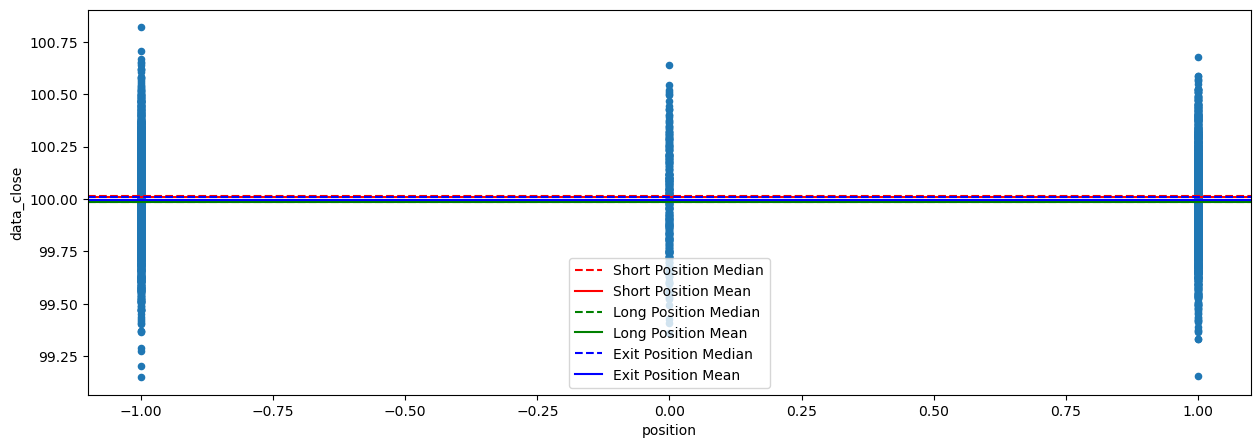

In [53]:
ax = df_historical_info.plot(x="position", y="data_close", kind="scatter", figsize=(15, 5))
short_pos_median = df_historical_info.loc[df_historical_info["position"] == -1, "data_close"].median()
short_pos_mean = df_historical_info.loc[df_historical_info["position"] == -1, "data_close"].mean()
long_pos_median = df_historical_info.loc[df_historical_info["position"] == 1, "data_close"].median()
long_pos_mean = df_historical_info.loc[df_historical_info["position"] == 1, "data_close"].mean()
exit_pos_median = df_historical_info.loc[df_historical_info["position"] == 0, "data_close"].median()
exit_pos_mean = df_historical_info.loc[df_historical_info["position"] == 0, "data_close"].mean()

ax.axhline(short_pos_median, color="red", linestyle="--", label="Short Position Median")
ax.axhline(short_pos_mean, color="red", linestyle="-", label="Short Position Mean")
ax.axhline(long_pos_median, color="green", linestyle="--", label="Long Position Median")
ax.axhline(long_pos_mean, color="green", linestyle="-", label="Long Position Mean")
ax.axhline(exit_pos_median, color="blue", linestyle="--", label="Exit Position Median")
ax.axhline(exit_pos_mean, color="blue", linestyle="-", label="Exit Position Mean")
ax.legend()